## Language > Subspaces

In these experiments, we aim to finetune a model that maps concept descriptions to subspace representations. Our goal is to find a model that generates subspace representations corresponding to the concept descriptions. We also hope this model generalizes to unseen concepts.

#### Set-ups

In [1]:
import torch, json, random, einops
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoModelForCausalLM, 
    AutoTokenizer, 
    AdamW,
    get_linear_schedule_with_warmup
)
from tqdm import tqdm
import matplotlib.pyplot as plt

/u/nlp/anaconda/main/anaconda3/envs/wuzhengx-310/lib/python3.10/site-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [2]:
def load_jsonl(jsonl_path):
    """
    Load data from a JSON lines file.
    """
    jsonl_data = []
    with open(jsonl_path, 'r') as f:
        for line in f:
            data = json.loads(line)
            jsonl_data += [data]
    return jsonl_data

def get_logits(model, tokenizer, concept_subspace, k=10):
    top_logits, neg_logits = [None], [None]

    W_U = model.lm_head.weight.T
    W_U = W_U * (model.model.norm.weight +
                torch.ones_like(model.model.norm.weight))[:, None]
    W_U -= einops.reduce(
        W_U, "d_model d_vocab -> 1 d_vocab", "mean"
    )

    vocab_logits = concept_subspace @ W_U
    top_values, top_indices = vocab_logits.topk(k=k, sorted=True)
    top_tokens = tokenizer.batch_decode(top_indices.unsqueeze(dim=-1))
    top_logits = [list(zip(top_tokens, top_values.tolist()))]
    
    neg_values, neg_indices = vocab_logits.topk(k=k, largest=False, sorted=True)
    neg_tokens = tokenizer.batch_decode(neg_indices.unsqueeze(dim=-1))
    neg_logits = [list(zip(neg_tokens, neg_values.tolist()))]

    return top_logits, neg_logits

class MyDataset(Dataset):
    def __init__(self, x_list, y_list):
        self.x_list = x_list
        self.y_list = y_list
        
    def __len__(self):
        return len(self.x_list)
    
    def __getitem__(self, idx):
        return self.x_list[idx], self.y_list[idx]

def my_collate_fn(batch):
    x_texts, y_tensors = zip(*batch)
    encodings = base_tokenizer(
        list(x_texts),
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=512
    )
    y_tensors = torch.stack(y_tensors, dim=0)
    return encodings, y_tensors

class RegressionWrapper(nn.Module):
    def __init__(self, base_model, hidden_size, output_dim):
        super().__init__()
        self.base_model = base_model
        self.regression_head = nn.Linear(hidden_size, output_dim)

    def forward(self, input_ids, attention_mask):
        outputs = self.base_model.model(
            input_ids=input_ids, 
            attention_mask=attention_mask,
            output_hidden_states=True,
            return_dict=True
        )
        last_hiddens = outputs.hidden_states[-1]
        last_token_representations = last_hiddens[:, -1]
        preds = self.regression_head(last_token_representations)
        preds = F.normalize(preds, p=2, dim=-1)
        return preds

In [3]:
model_name = "9b"
layer = "l20"

In [21]:
lsreft = torch.load(f"../results/prod_{model_name}_{layer}_concept16k_lsreft/train/LsReFT_weight.pt")
lsreft_metadata = load_jsonl(f"../results/prod_{model_name}_{layer}_concept16k_lsreft/train/metadata.jsonl")
assert lsreft.shape[0] == len(lsreft_metadata)

#### Unembed learned subspace

We can follow unembed the learned subspace to output tokens, and get top ranked tokens that are related to the learned subspace.

In [11]:
# Load the interpreting model
model = AutoModelForCausalLM.from_pretrained(
    f"google/gemma-2-{model_name}-it", torch_dtype=torch.bfloat16)
_ = model.cuda()
tokenizer = AutoTokenizer.from_pretrained(
    f"google/gemma-2-{model_name}-it", model_max_length=512)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [85]:
# Get a random subspace and its label
concept_id = random.randint(0, lsreft.shape[0] - 1)
concept_id

15407

In [86]:
concept_subspace = lsreft[concept_id].cuda()
print("Concept:", lsreft_metadata[concept_id]["concept"])

Concept: themes of friendship and personal relationships


In [87]:
get_logits(model, tokenizer, concept_subspace, k=5)

([[(' relationships', 0.609375),
   (' amistad', 0.60546875),
   (' friendships', 0.58984375),
   (' amizade', 0.5703125),
   (' friends', 0.515625)]],
 [[(' Paglinawan', -0.6015625),
   ('出版年', -0.5859375),
   ('bootstrapcdn', -0.578125),
   (' AssemblyCulture', -0.5625),
   ('instancetype', -0.53125)]])

Nice! We are at least getting interpretable tokens that are closely related to the concept!

#### Training to map concept to subspace via learning

Let's first create some training / validation dataset:
```
input  : concept described in natural language
output : concept subspace
```

In [5]:
concept500 = load_jsonl(f"../concept500/prod_{model_name}_{layer}_v1/generate/metadata.jsonl")
test_concepts = set([md["concept"] for md in concept500])

x = [md["concept"] for md in lsreft_metadata if md["concept"] not in test_concepts]
selected_idx = set([])
for md_idx, md in enumerate(lsreft_metadata):
    if md["concept"] not in test_concepts:
        selected_idx.add(md_idx)
y = [lsreft[i] for i in selected_idx]
assert len(x) == len(y)

x_train, x_test = x[:-500], x[-500:]
y_train, y_test = y[:-500], y[-500:]

train_dataset = MyDataset(x_train, y_train)
val_dataset   = MyDataset(x_test, y_test)
train_loader  = DataLoader(train_dataset, batch_size=12, shuffle=True, collate_fn=my_collate_fn)
val_loader    = DataLoader(val_dataset,   batch_size=128, shuffle=False, collate_fn=my_collate_fn)

We will finetune our language model to predict `y` from `x`

In [6]:
# Load the interpreting model
base_model = AutoModelForCausalLM.from_pretrained(
    f"google/gemma-2-2b", torch_dtype=torch.bfloat16)
_ = base_model.cuda()
base_tokenizer = AutoTokenizer.from_pretrained(
    f"google/gemma-2-2b", model_max_length=512)

hidden_size = base_model.config.hidden_size
output_dim = y_train[0].shape[-1]
subspace_gen = RegressionWrapper(base_model, hidden_size, output_dim).bfloat16().to("cuda")

epochs = 24
learning_rate = 8e-5

optimizer = AdamW(subspace_gen.parameters(), lr=learning_rate, weight_decay=0.0)
mse_criterion = nn.MSELoss(reduction="none")

num_training_steps = epochs * len(train_loader)
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

/u/nlp/anaconda/main/anaconda3/envs/wuzhengx-310/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [7]:
train_losses = []
val_losses = []

do_eval = True
patience = 3
best_val_loss = float('inf')
no_improvement_count = 0

for epoch in range(epochs):
    subspace_gen.train()
    epoch_train_loss = 0.0
    
    # Wrap your dataloader with tqdm so you get a progress bar
    pbar = tqdm(train_loader, 
                total=len(train_loader), 
                desc=f"Epoch {epoch+1}/{epochs}", 
                leave=False)

    for batch_idx, (encodings, y_true) in enumerate(pbar):
        input_ids = encodings["input_ids"].to("cuda")
        attention_mask = encodings["attention_mask"].to("cuda")
        y_true = y_true.to("cuda")

        optimizer.zero_grad()

        # Forward pass
        y_pred = subspace_gen(input_ids, attention_mask)
        
        # Compute loss
        mse_loss = mse_criterion(y_pred, y_true) 
        mse_loss = mse_loss.sum(dim=-1).mean()
        similarity = F.cosine_similarity(y_pred, y_true, dim=-1)  # shape: [batch_size]
        cos_loss = 1.0 - similarity.mean()
        loss = mse_loss + cos_loss
        
        loss.backward()
        
        optimizer.step()
        scheduler.step()
        
        # Accumulate training loss
        epoch_train_loss += loss.item()
        
        # Update tqdm progress bar with current loss
        pbar.set_postfix({"train_loss": f"{loss.item():.4f}"})

    # Average training loss for the epoch
    epoch_train_loss /= len(train_loader)
    train_losses.append(epoch_train_loss)

    # Evaluate if needed
    if do_eval:
        subspace_gen.eval()
        epoch_val_loss = 0.0
        with torch.no_grad():
            for encodings, y_true in val_loader:
                input_ids = encodings["input_ids"].to("cuda")
                attention_mask = encodings["attention_mask"].to("cuda")
                y_true = y_true.to("cuda")
                
                y_pred = subspace_gen(input_ids, attention_mask)
                
                mse_loss = mse_criterion(y_pred, y_true) 
                mse_loss = mse_loss.sum(dim=-1).mean()
                similarity = F.cosine_similarity(y_pred, y_true, dim=-1)  # shape: [batch_size]
                cos_loss = 1.0 - similarity.mean()
                loss = mse_loss + cos_loss
            
                epoch_val_loss += loss.item()
        
        epoch_val_loss /= len(val_loader)
        val_losses.append(epoch_val_loss)

        # Print current epoch results
        print(f"Epoch [{epoch+1}/{epochs}] | "
              f"Train Loss: {epoch_train_loss:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f}")

        # Early stopping check
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            no_improvement_count = 0
        else:
            no_improvement_count += 1
            if no_improvement_count == patience:
                print("Early stopping triggered: validation loss did not improve.")
                break
    else:
        print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {epoch_train_loss:.4f}")

Epoch [1/24] | Train Loss: 0.8683 | Val Loss: 0.7705


Epoch [2/24] | Train Loss: 0.7452 | Val Loss: 0.7168


Epoch [3/24] | Train Loss: 0.6746 | Val Loss: 0.6895


Epoch [4/24] | Train Loss: 0.6227 | Val Loss: 0.6514


Epoch [5/24] | Train Loss: 0.5815 | Val Loss: 0.6553


Epoch [6/24] | Train Loss: 0.5442 | Val Loss: 0.6260


Epoch [7/24] | Train Loss: 0.5249 | Val Loss: 0.6416


Epoch [8/24] | Train Loss: 0.5019 | Val Loss: 0.6250


Epoch [9/24] | Train Loss: 0.4788 | Val Loss: 0.6182


Epoch [10/24] | Train Loss: 0.4468 | Val Loss: 0.6113


Epoch [11/24] | Train Loss: 0.4317 | Val Loss: 0.6162


Epoch [12/24] | Train Loss: 0.4162 | Val Loss: 0.6045


Epoch [13/24] | Train Loss: 0.3898 | Val Loss: 0.6162


Epoch [14/24] | Train Loss: 0.3748 | Val Loss: 0.6182


Epoch [15/24] | Train Loss: 0.3616 | Val Loss: 0.6191
Early stopping triggered: validation loss did not improve.


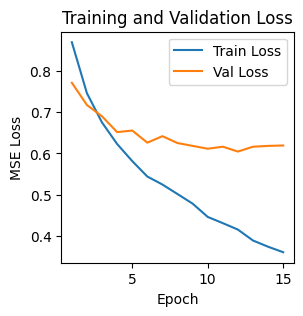

In [8]:
plt.figure(figsize=(3,3))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
if do_eval:
    plt.plot(range(1, len(val_losses)+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [9]:
# save losses.
loss_data = {
    'Epoch': list(range(1, len(train_losses) + 1)),
    'Train Loss': train_losses
}
if do_eval:
    loss_data['Val Loss'] = val_losses
df_losses = pd.DataFrame(loss_data)
csv_filename = f'subspace_gen_{model_name}_{layer}_loss_data.csv'  # You can change the filename as needed
df_losses.to_csv(csv_filename, index=False)
print(f"Raw loss data saved as '{csv_filename}'.")

Raw loss data saved as 'subspace_gen_9b_l20_loss_data.csv'.


In [10]:
# optionally, you can save this subspace generator
torch.save(subspace_gen.state_dict(), f'subspace_generator_{model_name}_{layer}.pth')
print("Final model saved to subspace_generator.pth")

Final model saved to subspace_generator.pth


In [7]:
# optionally, you load from saved weights
subspace_gen.load_state_dict(torch.load(f'subspace_generator_{model_name}_{layer}.pth'))
print("Loading model from saved file subspace_generator.pth")

Loading model from saved file subspace_generator.pth


#### Inference with mapping new concept to subspace

The training loss looks great! Let's now test with new concepts.

In [88]:
your_new_concept = "terms related to Stanford University"

In [89]:
subspace_gen.eval()
model.eval()
inputs = base_tokenizer(your_new_concept, return_tensors="pt").to("cuda")
input_ids, attention_mask = inputs["input_ids"], inputs["attention_mask"]
your_subspace = subspace_gen(input_ids, attention_mask)[0]

In [90]:
get_logits(model, base_tokenizer, your_subspace, k=10)

([[('PhysRev', 0.462890625),
   (' للمعارف', 0.451171875),
   ('ValueStyle', 0.40625),
   ('onViewCreated', 0.388671875),
   ('텐츠', 0.388671875),
   (' Graduate', 0.384765625),
   (' students', 0.3828125),
   (' professors', 0.380859375),
   ('chartInstance', 0.37890625),
   ('FormState', 0.373046875)]],
 [[(' Audiodateien', -0.5625),
   ('Personendaten', -0.53515625),
   ('WriteTagHelper', -0.48828125),
   ('moga', -0.43359375),
   (' íntima', -0.421875),
   ('onenumber', -0.412109375),
   ('HttpFoundation', -0.41015625),
   ('uelan', -0.41015625),
   ('DCHECK', -0.41015625),
   (' electrica', -0.40625)]])

#### Evaluate our subspace generator with `Concept500` (unseen concepts) just like other methods

In [91]:
concept500 = load_jsonl(f"../concept500/prod_{model_name}_{layer}_v1/generate/metadata.jsonl")
concept500_subspaces = []
for md in concept500:
    your_new_concept = md["concept"]
    inputs = base_tokenizer(your_new_concept, return_tensors="pt").to("cuda")
    input_ids, attention_mask = inputs["input_ids"], inputs["attention_mask"]
    your_subspace = subspace_gen(input_ids, attention_mask)[0]
    concept500_subspaces += [your_subspace]
concept500_subspaces = torch.stack(concept500_subspaces, dim=0)

In [92]:
# saving as other weight files
torch.save(concept500_subspaces, f"LsReFT_weight_{model_name}_{layer}_gen.pt")